# PETITE SM shower generation example

PETITE is a simple, lightweight, toy Monte Carlo that generates realistic electromagnetic showers. 

Authors: Kevin J. Kelly (Texas A&M), Nikita Blinov (U. Victoria), Ryan Plestid (Caltech), Patrick J. Fox (Fermilab), and Pedro A.M. Machado (Fermilab)

It includes explicit simulation of (we denote nuclei by their electric charge $Z$)

* Bremsstrahlung  $e^\pm Z \rightarrow e^\pm \gamma Z$. 
* Pair production $\gamma Z \rightarrow e^+ e^- Z$. 
* Compton scattering $\gamma e^- \rightarrow  \gamma e^-$
* Pair-annihilation $e^+ e^- \rightarrow \gamma\gamma$ 
* Moller Scattering $e^- e^- \rightarrow e^- e^-$
* Bhabha Scattering $e^+ e^- \rightarrow e^+ e^-$

and implicit simulation of 

* Multiple Coulomb scattering
* Energy loss by ionization 

${\bf Dependencies}$: numpy, vegas, pickle, cProfile, tqdm, scipy

${\bf Version~ requirements}$: numpy 1.24  ,  python3.xx with xx$\geq$9.

${\bf Directory~structure}$: This notebook assumes that within a PETITE home directory there is folder containing dictionaries, and that within that folder the following files exist 

* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/Feb13_xSec_Dicts.pkl
* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/Mar24_xSec_Dicts.pkl
* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/Mar24_xSec_Dicts_neval.pkl

You can check versions with the code below and adjust if necessary

In [1]:
from platform import python_version
print("Python version: ", python_version())

import numpy
print("Numpy version: ", numpy.__version__)

import os
current_path = os.getcwd()
PETITE_home_dir= current_path.split('examples')[0]

print("PETITE home directory:", PETITE_home_dir)

dictionary_dir = "RyanDicts/"

Python version:  3.10.6
Numpy version:  1.24.3
PETITE home directory: /Users/kjkelly/Documents/GitHub/PETITE/


### Load in dependencies and set font styles

In [2]:
#from kjkutils import *
from PETITE.shower import *
import pickle as pk
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib

from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator, MaxNLocator
import cProfile
profile = cProfile.Profile()
import pstats

font0 = FontProperties()
font = font0.copy()
font.set_size(24)
font.set_family('serif')
labelfont=font0.copy()
labelfont.set_size(20)
labelfont.set_weight('bold')
legfont=font0.copy()
legfont.set_size(18)
legfont.set_weight('bold')


def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)



####  Import two shower objects, one with a graphite target and one with lead. Both track down to minimum energies of 10 MeV

The minimum energy in the shower dictates the run-time. As one attempts to simulate lower-threshold IR physics, the computational cost increases exponentially. The number of low energy particles proliferates and one encounters many compton scatters.  10 MeV allows for reasonable simulation speed. 

Pre-loaded materials are lead and graphite, but other materials can be included straightforwardly running other scripts in the PETITE utilities folder

In [3]:
sGraphite = Shower(PETITE_home_dir+dictionary_dir, "graphite", 0.010)
sLead = Shower(PETITE_home_dir+dictionary_dir, "lead", 0.010)

Now we create a list of energies to be used in the simulation.

In [4]:
EVec = np.logspace(np.log10(0.0015), np.log10(100.), 100)
EVec[58], EVec[73]

(1.0051239289306901, 5.4089737788907355)

In [5]:
Phot0 = Particle(22, 10, 0, 0, 10, 0, 0, 0, 1, 0, 22, 0, -1, 1)
epsplus = []
for k in tqdm(range(int(1e5))):
    epsplus.append(sGraphite.pairprod_sample(Phot0)[1].get_p0()[0])

Phot05 = Particle(22, 5, 0, 0, 5, 0, 0, 0, 1, 0, 22, 0, -1, 1)
epsplus5 = []
for k in tqdm(range(int(1e5))):
    epsplus5.append(sGraphite.pairprod_sample(Phot05)[1].get_p0()[0])

Phot0100 = Particle(22, 100, 0, 0, 100, 0, 0, 0, 1, 0, 22, 0, -1, 1)
epsplus100 = []
for k in tqdm(range(int(1e5))):
    epsplus100.append(sGraphite.pairprod_sample(Phot0100)[1].get_p0()[0])

 13%|█▎        | 13275/100000 [00:03<00:21, 4036.82it/s]


KeyboardInterrupt: 

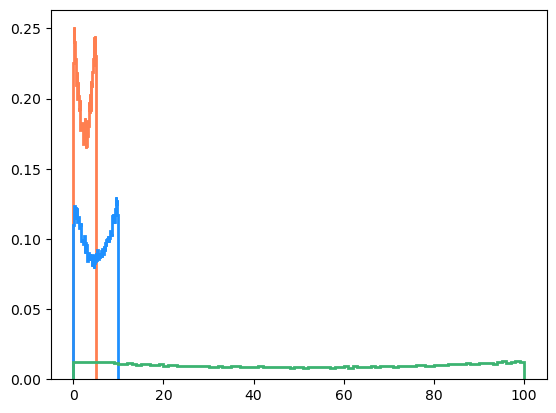

In [10]:
plt.hist(epsplus5, bins=np.linspace(0, 5, 101), histtype='step', color='coral', density=True, lw=2);
plt.hist(epsplus, bins=np.linspace(0, 10, 101), histtype='step', color='dodgerblue', density=True, lw=2);
plt.hist(epsplus100, bins=np.linspace(0, 100, 101), histtype='step', color='mediumseagreen', density=True, lw=2);

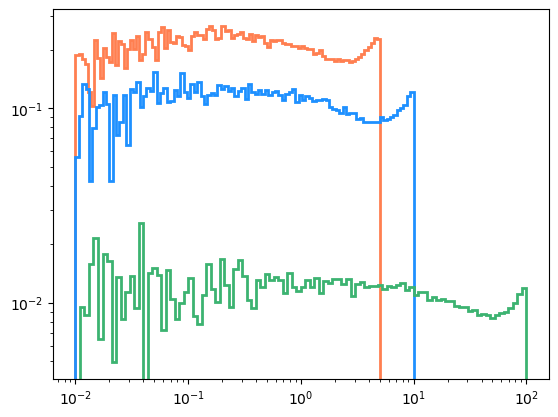

In [11]:
plt.hist(epsplus5, bins=np.logspace(-2, np.log10(5.0), 101), histtype='step', density=True, color='coral', lw=2);
plt.hist(epsplus, bins=np.logspace(-2, 1, 101), histtype='step', density=True, color='dodgerblue', lw=2);
plt.hist(epsplus100, bins=np.logspace(-2, 2, 101), histtype='step', density=True, color='mediumseagreen', lw=2);
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

## Accept/reject in PETITE
PETITE usese VEGAS intergrator objects pre-trained on a grid of incident particle energies. During a shower the nearest energy with ``good coverage'' is used to draw samples, and accept reject is performed with the diffential cross section at the true physical energy. 

As an illustration we set an incident electron energy at $E_{e} = 1 ~{\rm GeV}$, and sample from several integrators trained at nearby energies for the bremsstrahlung process $e Z \rightarrow e Z \gamma$. 

In [5]:
xs0 = []
trials0 = []
for k in range(int(1e5)):
    s0 = sGraphite.draw_sample(1.00512, 59, 'Moller', VB=True)
    xs0.append(s0[0])
    trials0.append(s0[-1])

xs1 = []
trials1 = []
for k in range(int(1e5)):
    s0 = sGraphite.draw_sample(1.00512, 60, 'Moller', VB=True)
    xs1.append(s0[0])
    trials1.append(s0[-1])

xs2 = []
trials2 = []
for k in range(int(1e5)):
    s0 = sGraphite.draw_sample(1.00512, 61, 'Moller', VB=True)
    xs2.append(s0[0])
    trials2.append(s0[-1])

xs3 = []
trials3 = []
for k in range(int(1e5)):
    s0 = sGraphite.draw_sample(1.00512, 62, 'Moller', VB=True)
    xs3.append(s0[0])
    trials3.append(s0[-1])

### Compare efficiency of sampling for different nearby energies

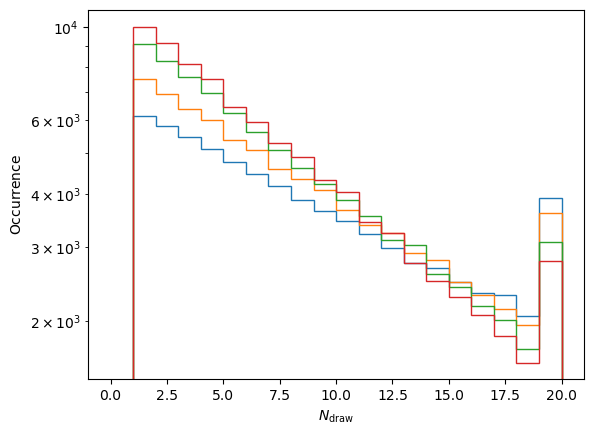

In [6]:
plt.hist(trials0, bins=np.linspace(0, 20, 21), histtype='step', lw=1)
plt.hist(trials1, bins=np.linspace(0, 20, 21), histtype='step', lw=1)
plt.hist(trials2, bins=np.linspace(0, 20, 21), histtype='step', lw=1)
plt.hist(trials3, bins=np.linspace(0, 20, 21), histtype='step', lw=1)
plt.gca().set_xlabel(r"$N_{\rm draw}$")
plt.gca().set_ylabel(r"$\mathrm{Occurrence}$")
plt.gca().set_yscale('log')

### Check distributions to see if they are insensitive to choice of integrator object

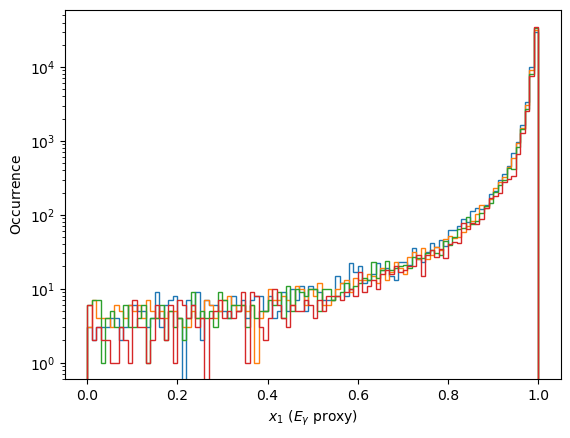

In [7]:
plt.hist(xs0, bins=np.linspace(0, 1, 101), histtype='step', lw=1)
plt.hist(xs1, bins=np.linspace(0, 1, 101), histtype='step', lw=1)
plt.hist(xs2, bins=np.linspace(0, 1, 101), histtype='step', lw=1)
plt.hist(xs3, bins=np.linspace(0, 1, 101), histtype='step', lw=1)
plt.gca().set_xlabel(r"$x_1\ (E_{\gamma}\ \rm{proxy})$")
plt.gca().set_ylabel(r"$\mathrm{Occurrence}$")
plt.gca().set_yscale('log')

## Use of rotated coordinates

PETITE uses small angle variables (see e.g. sections 92-94 of Landau and Lifshitz Vol 4). However low-momentum transfers occur along a correlated "ridge" in these variables. To improve performance we have rotated angles. 

We illustrate the difference in performance, and benchmark total cross sections computed using the VEGAS integrators below. 

In [5]:
dicts_old = pk.load(open(PETITE_home_dir+dictionary_dir+"Feb13_xSec_Dicts.pkl", "rb"))
#dicts_new = pk.load(open(PETITE_home_dir+dictionary_dir+"Mar24_xSec_Dicts.pkl", "rb"))
dicts_new_neval = pk.load(open(PETITE_home_dir+dictionary_dir+"xSec_Dicts.pkl", "rb"))

### Pair production

Cross sections are material dependent due to $Z^2$ scaling, but also due to atomic form factors (see e.g.\ Tsai Rev. Mod. Phys. (1974). 

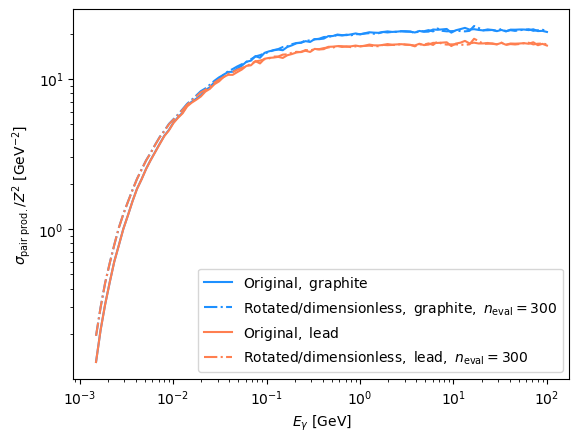

In [10]:
plt.plot(np.transpose(dicts_old['PairProd']['graphite'])[0], np.transpose(dicts_old['PairProd']['graphite'])[1]/6**2, color='dodgerblue', ls='-', label=r"$\mathrm{Original,\ graphite}$")
#plt.plot(np.transpose(dicts_new['PairProd']['graphite'])[0], np.transpose(dicts_new['PairProd']['graphite'])[1]/6**2, color='dodgerblue', ls='--', label=r"$\mathrm{Rotated/dimensionless,\ graphite}$")
plt.plot(np.transpose(dicts_new_neval['PairProd']['graphite'])[0], np.transpose(dicts_new_neval['PairProd']['graphite'])[1]/6**2, color='dodgerblue', ls='-.', label=r"$\mathrm{Rotated/dimensionless,\ graphite,\ }n_{\rm eval}=300$")
plt.plot(np.transpose(dicts_old['PairProd']['lead'])[0], np.transpose(dicts_old['PairProd']['lead'])[1]/82**2, color='coral', ls='-', label=r"$\mathrm{Original,\ lead}$")
#plt.plot(np.transpose(dicts_new['PairProd']['lead'])[0], np.transpose(dicts_new['PairProd']['lead'])[1]/82**2, color='coral', ls='--', label=r"$\mathrm{Rotated/dimensionless,\ lead}$")
plt.plot(np.transpose(dicts_new_neval['PairProd']['lead'])[0], np.transpose(dicts_new_neval['PairProd']['lead'])[1]/82**2, color='coral', ls='-.', label=r"$\mathrm{Rotated/dimensionless,\ lead,\ }n_{\rm eval}=300$")

plt.legend(loc='best')

plt.gca().set_xlabel(r"$E_{\gamma}\ [\mathrm{GeV}]$")
plt.gca().set_ylabel(r"$\sigma_{\rm pair\ prod.}/Z^2\ [\mathrm{GeV^{-2}}]$")

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')


### Bremsstrahlung

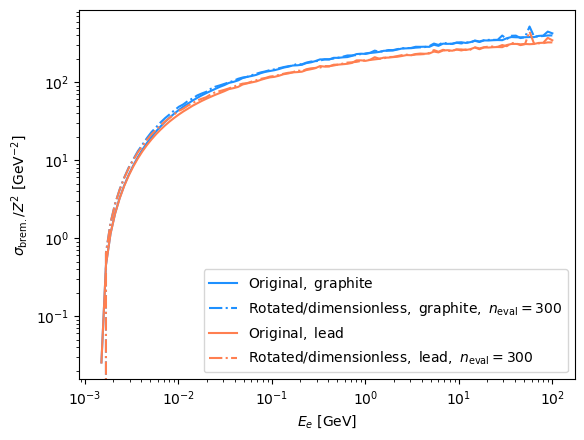

In [11]:
plt.plot(np.transpose(dicts_old['Brem']['graphite'])[0], np.transpose(dicts_old['Brem']['graphite'])[1]/6**2, color='dodgerblue', ls='-', label=r"$\mathrm{Original,\ graphite}$")
#plt.plot(np.transpose(dicts_new['Brem']['graphite'])[0], np.transpose(dicts_new['Brem']['graphite'])[1]/6**2, color='dodgerblue', ls='--', label=r"$\mathrm{Rotated/dimensionless,\ graphite}$")
plt.plot(np.transpose(dicts_new_neval['Brem']['graphite'])[0], np.transpose(dicts_new_neval['Brem']['graphite'])[1]/6**2, color='dodgerblue', ls='-.', label=r"$\mathrm{Rotated/dimensionless,\ graphite,\ }n_{\rm eval}=300$")
plt.plot(np.transpose(dicts_old['Brem']['lead'])[0], np.transpose(dicts_old['Brem']['lead'])[1]/82**2, color='coral', ls='-', label=r"$\mathrm{Original,\ lead}$")
#plt.plot(np.transpose(dicts_new['Brem']['lead'])[0], np.transpose(dicts_new['Brem']['lead'])[1]/82**2, color='coral', ls='--', label=r"$\mathrm{Rotated/dimensionless,\ lead}$")
plt.plot(np.transpose(dicts_new_neval['Brem']['lead'])[0], np.transpose(dicts_new_neval['Brem']['lead'])[1]/82**2, color='coral', ls='-.', label=r"$\mathrm{Rotated/dimensionless,\ lead,\ }n_{\rm eval}=300$")

plt.legend(loc='best')

plt.gca().set_xlabel(r"$E_{e}\ [\mathrm{GeV}]$")
plt.gca().set_ylabel(r"$\sigma_{\rm brem.}/Z^2\ [\mathrm{GeV^{-2}}]$")

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')


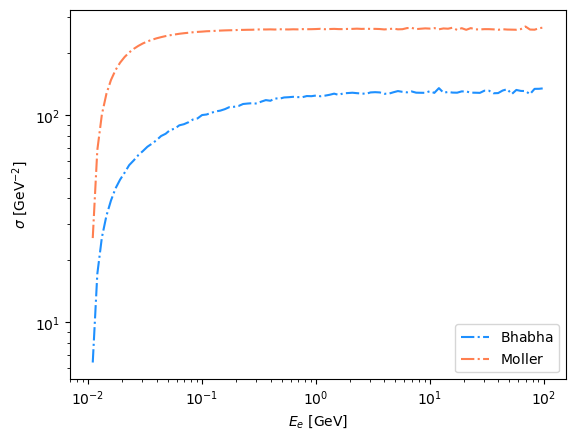

In [10]:
plt.plot(np.transpose(dicts_new_neval['Bhabha']['graphite'])[0], np.transpose(dicts_new_neval['Bhabha']['graphite'])[1], color='dodgerblue', ls='-.', label=r"$\mathrm{Bhabha}$")
plt.plot(np.transpose(dicts_new_neval['Moller']['graphite'])[0], np.transpose(dicts_new_neval['Moller']['graphite'])[1], color='coral', ls='-.', label=r"$\mathrm{Moller}$")

plt.legend(loc='best')

plt.gca().set_xlabel(r"$E_{e}\ [\mathrm{GeV}]$")
plt.gca().set_ylabel(r"$\sigma\ [\mathrm{GeV^{-2}}]$")

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')


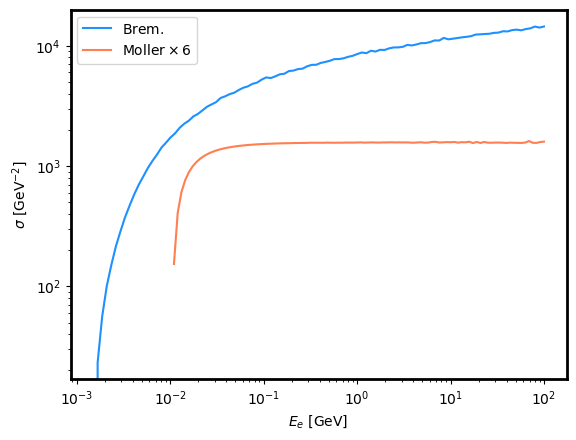

In [20]:
plt.plot(np.transpose(dicts_new_neval['Brem']['graphite'])[0], np.transpose(dicts_new_neval['Brem']['graphite'])[1], color='dodgerblue', ls='-', label=r"$\mathrm{Brem.}$")
plt.plot(np.transpose(dicts_new_neval['Moller']['graphite'])[0], np.transpose(dicts_new_neval['Moller']['graphite'])[1]*6, color='coral', ls='-', label=r"$\mathrm{Moller}\times 6$")

plt.legend(loc='best')

plt.gca().set_xlabel(r"$E_{e}\ [\mathrm{GeV}]$")
plt.gca().set_ylabel(r"$\sigma\ [\mathrm{GeV^{-2}}]$")

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')


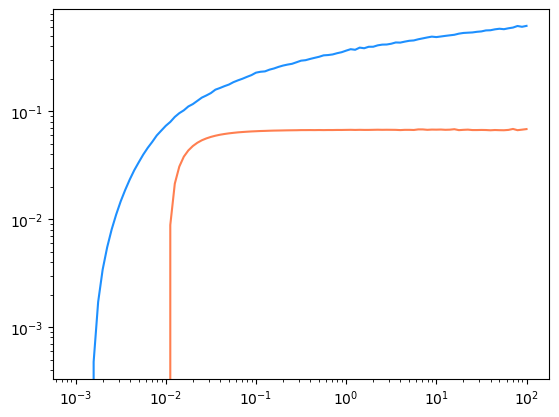

In [6]:
EVec = np.logspace(-3, 2, 101)
plt.plot(EVec, sGraphite._NSigmaBrem(EVec), ls='-', color='dodgerblue')
plt.plot(EVec, sGraphite._NSigmaMoller(EVec), ls='-', color='coral')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

## Shower production with PETITE

The primary purpose of PETITE is to produce realistic electromagnetic showers with a lightweight, reasonably fast, python-native code base. We illustrate its performance below. 

We will shoot a 10 GeV particle incident on either lead or graphite. Particles are specified by their PDG codes (see e.g. https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf) 


* ${\rm PDG}(e^\pm)=\pm11$ 
* ${\rm PDG}(\gamma)~~=+22$ 


In [8]:
E0 = 10.
p0 = Particle(11, E0, 0., 0., np.sqrt(E0**2 - 0.000511**2), 0, 0, 0, 1, 0, 0, 0, -1, 1.)
p0G = Particle(22, E0, 0, 0, E0, 0, 0, 0, 1, 0, 0, 0, -1, 1.)

Check shower timing

In [9]:
def slowShower():
    s0 = sGraphite.generate_shower(11, p0.get_p0(), 22, VB=True)
    return

We use the package cProfile to return useful information on the runtime. This is helpful if one would like to change $E_{\rm min}$ which can slow down the code. The output below is helpful in diagnosing bottlenecks etc.

In [10]:
profileSS = cProfile.Profile()
profileSS.runcall(slowShower)
psSS = pstats.Stats(profileSS)
psSS.print_stats()

Starting shower, initial particle with ID Info
[11.  1. 22.  0.  0. -1.  1.]
Initial four-momenta:
[10.          0.          0.          9.99999999]
         1792939 function calls (1785874 primitive calls) in 0.688 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    16240    0.001    0.000    0.001    0.000 {method 'append' of 'list' objects}
      838    0.000    0.000    0.000    0.000 {method 'bit_length' of 'int' objects}
     1788    0.000    0.000    0.000    0.000 {method 'get' of 'dict' objects}
     6435    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
        2    0.000    0.000    0.000    0.000 {method 'update' of 'dict' objects}
        2    0.000    0.000    0.000    0.000 {method 'copy' of 'dict' objects}
        2    0.000    0.000    0.000    0.000 {method 'add' of 'set' objects}
        2    0.000    0.000    0.000    0.000 {method 'discard' of 'set' objects}
       11    0.000  

### Generate showes for graphite and lead

The following code generates a shower initiated by a 10 GeV electron.  To see how functions work you may call their docstrings

In [10]:
print(sGraphite.generate_shower.__doc__)


        Generates particle shower from an initial particle
        Args:
            PID0: PDG ID of the initial particle
            p40: four-momentum of the initial particle
            ParID: PDG ID of the parent of the initial particle
            VB: bool to turn on/off verbose output

        Returns:
            AllParticles: a list of all particles generated in the shower
        


####  You supply a "parent" for the initial electron. PETITE thinks of each particle as a successive daughter of its ancestors. We supply a parent particle as a photon, but this does not influence the generation of the shower 

In [21]:
SMS = sGraphite.generate_shower(11, p0.get_p0(), 22, VB=True)
SMSLead = sLead.generate_shower(11, p0.get_p0(), 22, VB=True)

Starting shower, initial particle with ID Info
[11.  1. 22.  0.  0. -1.  1.]
Initial four-momenta:
[10.          0.          0.          9.99999999]
Starting shower, initial particle with ID Info
[11.  1. 22.  0.  0. -1.  1.]
Initial four-momenta:
[10.          0.          0.          9.99999999]


### Get all the photons, electrons, and positrons in the shower

We take the array from graphite SMS, and we find all the particles that match the relevant PID

In [22]:
SMSPhotons = np.array(SMS)[np.where([ps.get_ids()[0] == 22 for ps in SMS])[0]]
SMSPhotonsLead = np.array(SMSLead)[np.where([ps.get_ids()[0] == 22 for ps in SMSLead])[0]]
SMSElectrons = np.array(SMS)[np.where([ps.get_ids()[0] == 11 for ps in SMS])[0]]
SMSPositrons = np.array(SMS)[np.where([ps.get_ids()[0] == -11 for ps in SMS])[0]]

In [23]:
PhotonEs = np.array([s.get_p0()[0] for s in SMSPhotons])
PhotonEsLead = np.array([s.get_p0()[0] for s in SMSPhotonsLead])

In [24]:
ElectronEs = np.array([s.get_p0()[0] for s in SMSElectrons])
PositronEs = np.array([s.get_p0()[0] for s in SMSPositrons])


In [25]:
len(PhotonEs)

192

### Plot the integrated distribution of photons in a shower with respect to their energy

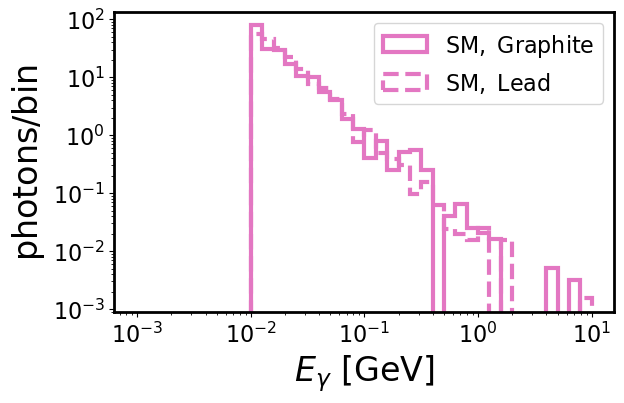

In [26]:
b0 = np.logspace(-3, 1, 41)

plt.hist(PhotonEs, bins=b0, histtype='step', lw=3, color='C6', density=True, ls='-', label=r"$\mathrm{SM,\ Graphite}$")
plt.hist(PhotonEsLead, bins=b0, histtype='step', lw=3, color='C6', density=True, ls='--', label=r"$\mathrm{SM,\ Lead}$")

plt.gca().legend(loc=1, fontsize=16)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_\gamma\ [\mathrm{GeV}]$", fontsize=24)
plt.gca().set_ylabel(r"$\mathrm{photons/bin}$", fontsize=24)
#plt.gca().axis([1e-3,100,1e-11,1e-3])
[l.set_size(16) for l in plt.gca().get_xticklabels()]
[l.set_size(16) for l in plt.gca().get_yticklabels()]

set_size(5.0, 3.0)


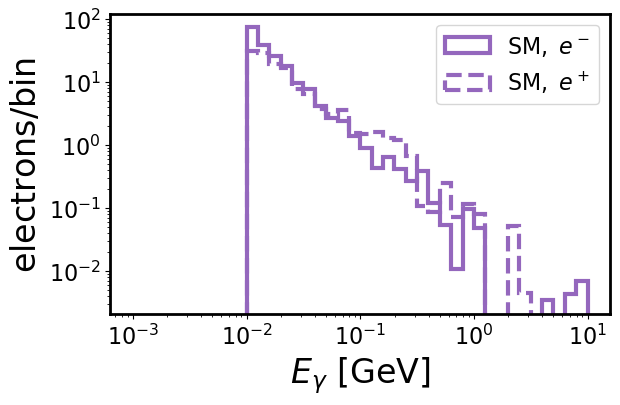

In [27]:
b0 = np.logspace(-3, 1, 41)

plt.hist(ElectronEs, bins=b0, histtype='step', lw=3, color='C4', density=True, ls='-', label=r"$\mathrm{SM,\ } e^-$")
plt.hist(PositronEs, bins=b0, histtype='step', lw=3, color='C4', density=True, ls='--', label=r"$\mathrm{SM,\ } e^+$")

plt.gca().legend(loc=1, fontsize=16)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_\gamma\ [\mathrm{GeV}]$", fontsize=24)
plt.gca().set_ylabel(r"$\mathrm{electrons/bin}$", fontsize=24)
#plt.gca().axis([1e-3,100,1e-11,1e-3])
[l.set_size(16) for l in plt.gca().get_xticklabels()]
[l.set_size(16) for l in plt.gca().get_yticklabels()]

set_size(5.0, 3.0)


## Event displays

PETITE can be used to produce event displays for electromagnetic showers. The relevant loop of code (beyond plotting aesthetics) is highlighted below.  

Each event in the shower contains information on its location of "production" $\mathbf{r}_0$ and its location of "destruction" $\mathbf{r}_f$. Here, production and destruction only refer to being tracked in the simulation. For example, an atomic electron that is ionized by compton scattering with energy above $10~{\rm MeV}$ is "produced", and a $12~{\rm MeV}$ electron that looses $4 ~{\rm MeV}$ of energy falls below the $10~{\rm MeV}$ threshold of the simulation and is "destroyed". 

In [18]:
print("The location of production for particle 12:", SMS[12].get_r0())
print("The location of destruction for particle 12:", SMS[12].get_rf())


The location of production for particle 12: [-6.11115796e-05  2.03418799e-05  5.42868029e-02]
The location of destruction for particle 12: [-0.007255928102778746, -0.014899258396541977, 0.11251386063026586]


### We can use these function to make event displays

The particles in SMS are sorted by their PID, and plotted as either squiggly green lines (photons), straight red lines (electrons) or straight blue lines (positrons). 

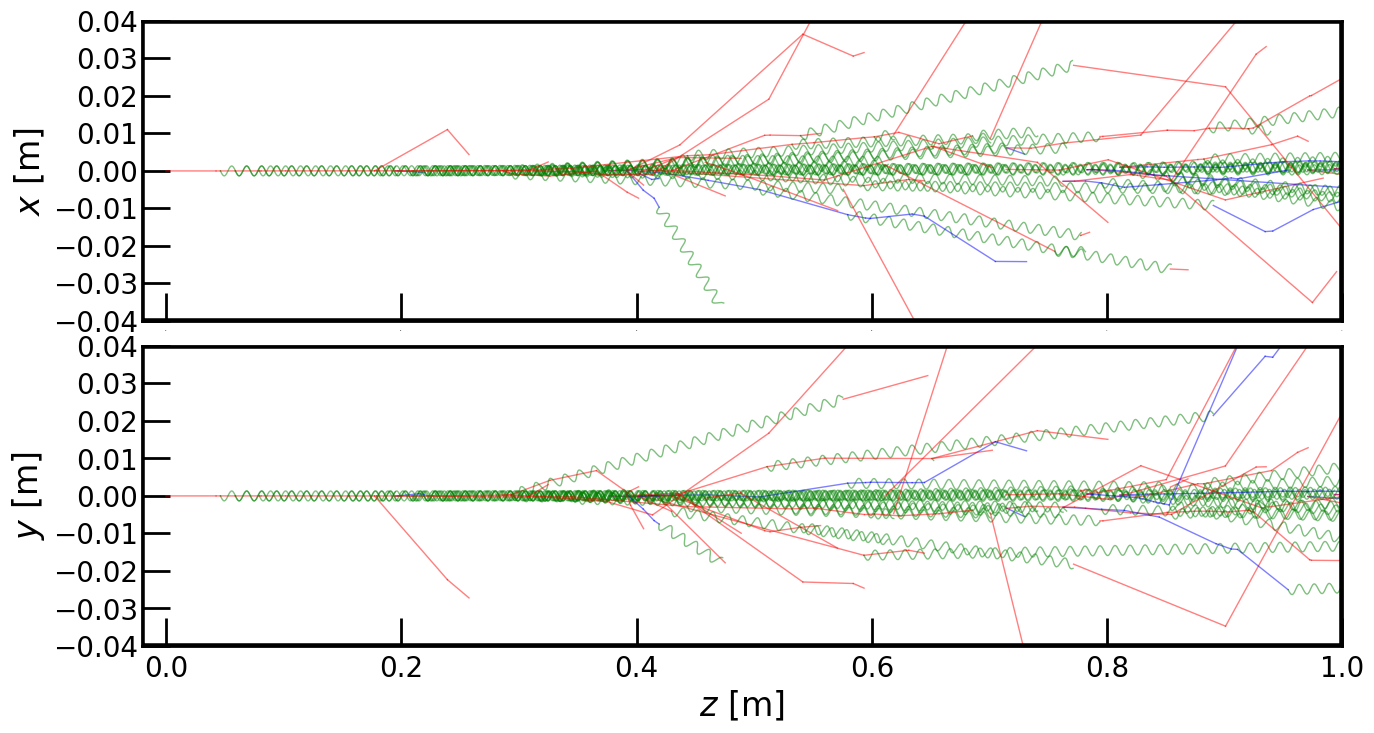

In [28]:
figwid = 6.0*2.0
fighei = 6.0*0.5
lside = 3.0
rside = 3.5
wwspace = 1.25

ncol = 1
nrow = 2

wid = lside + ncol*figwid + (ncol-1)*wwspace + rside

bot = 3.77
top = 3.5
hhspace = 0.25

hei = bot + nrow*fighei + (nrow-1)*hhspace + top

lfactor = lside/wid
rfactor = rside/wid
bfactor = bot/hei
tfactor = top/hei
wfactor = wwspace/figwid
hfactor = hhspace/fighei

matplotlib.rcParams['axes.linewidth'] = 2.0
fig, axes = plt.subplots(nrow, ncol, figsize=(wid, hei), facecolor='1.0');
fig.subplots_adjust(left = lfactor, bottom=bfactor, right=(1.0-rfactor), top=(1.0-tfactor), wspace=wfactor, hspace=hfactor);

xmin, xmax, ymin, ymax = -0.02, 1, -0.04, 0.04
#xmin, xmax, ymin, ymax = -1.0, 5.0, -0.4, 0.4

ax = axes[0]
ax.axis([xmin, xmax, ymin, ymax])
ax.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], ls='-', color='k', lw=4, zorder=50)
#ax.set_xlabel(r'$z\ [\mathrm{m}]$', fontproperties=font)        
ax.set_ylabel(r'$x\ [\mathrm{m}]$', fontproperties=font)        

ax.tick_params(direction='in', zorder=30, length=20, width=2)
ax.tick_params(direction='in', which='minor', zorder=30, length=15, width=1.5)
[l.set_position((0.5, -0.015)) for l in ax.get_xticklabels()]
[l.set_size((0)) for l in ax.get_xticklabels()]
[l.set_size((labelfont.get_size())) for l in ax.get_yticklabels()]

for ki0 in SMS:
    ki = np.concatenate([ki0.get_r0(), ki0.get_rf()])
    if ki0.get_ids()[0] == 22:
        with matplotlib.rc_context({'path.sketch': (5, 15, 1)}):
            ax.plot([ki[2], ki[5]], [ki[0], ki[3]], lw=1, ls='-', color='g', alpha=0.5)
    if ki0.get_ids()[0] == 11:
        ax.plot([ki[2], ki[5]], [ki[0], ki[3]], lw=1, ls='-', color='r', alpha=0.5)
    if ki0.get_ids()[0] == -11:
        ax.plot([ki[2], ki[5]], [ki[0], ki[3]], lw=1, ls='-', color='b', alpha=0.5)

ax = axes[1]
ax.axis([xmin, xmax, ymin, ymax])
ax.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], ls='-', color='k', lw=4, zorder=50)
ax.set_xlabel(r'$z\ [\mathrm{m}]$', fontproperties=font)        
ax.set_ylabel(r'$y\ [\mathrm{m}]$', fontproperties=font)        

ax.tick_params(direction='in', zorder=30, length=20, width=2)
ax.tick_params(direction='in', which='minor', zorder=30, length=15, width=1.5)
[l.set_position((0.5, -0.015)) for l in ax.get_xticklabels()]
[l.set_size((labelfont.get_size())) for l in ax.get_xticklabels()]
[l.set_size((labelfont.get_size())) for l in ax.get_yticklabels()]

for ki0 in SMS:
    ki = np.concatenate([ki0.get_r0(), ki0.get_rf()])
    if ki0.get_ids()[0] == 22:
        with matplotlib.rc_context({'path.sketch': (5, 15, 1)}):
            ax.plot([ki[2], ki[5]], [ki[1], ki[4]], lw=1, ls='-', color='g', alpha=0.5)
    if ki0.get_ids()[0] == 11:
        ax.plot([ki[2], ki[5]], [ki[1], ki[4]], lw=1, ls='-', color='r', alpha=0.5)
    if ki0.get_ids()[0] == -11:
        ax.plot([ki[2], ki[5]], [ki[1], ki[4]], lw=1, ls='-', color='b', alpha=0.5)



### Comparison of lead vs graphite

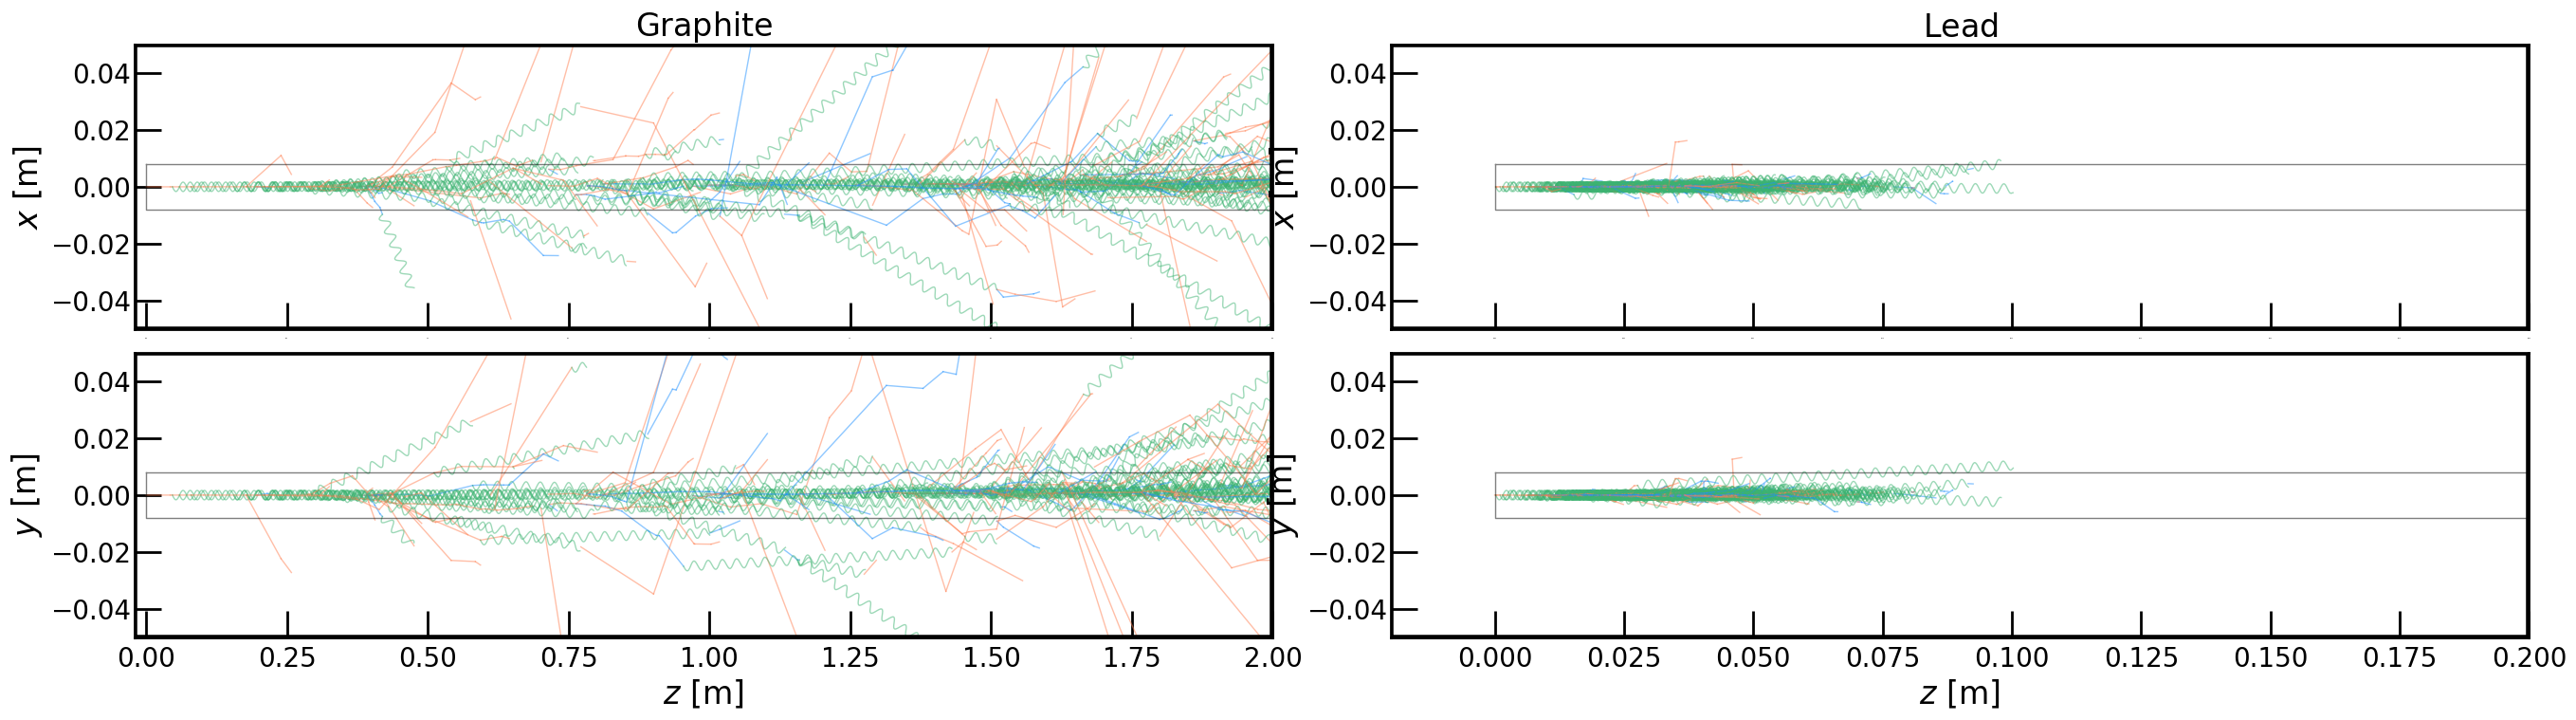

In [29]:
figwid = 6.0*2.0
fighei = 6.0*0.5
lside = 3.0
rside = 3.5
wwspace = 1.25

ncol = 2
nrow = 2

wid = lside + ncol*figwid + (ncol-1)*wwspace + rside

bot = 3.77
top = 3.5
hhspace = 0.25

hei = bot + nrow*fighei + (nrow-1)*hhspace + top

lfactor = lside/wid
rfactor = rside/wid
bfactor = bot/hei
tfactor = top/hei
wfactor = wwspace/figwid
hfactor = hhspace/fighei

matplotlib.rcParams['axes.linewidth'] = 2.0
fig, axes = plt.subplots(nrow, ncol, figsize=(wid, hei), facecolor='1.0');
fig.subplots_adjust(left = lfactor, bottom=bfactor, right=(1.0-rfactor), top=(1.0-tfactor), wspace=wfactor, hspace=hfactor);

xmin, xmax, ymin, ymax = -0.02, 2, -0.05, 0.05
#xmin, xmax, ymin, ymax = -1.0, 5.0, -0.4, 0.4

ax = axes[0][0]
ax.axis([xmin, xmax, ymin, ymax])
ax.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], ls='-', color='k', lw=4, zorder=50)
#ax.set_xlabel(r'$z\ [\mathrm{m}]$', fontproperties=font)        
ax.set_ylabel(r'$x\ [\mathrm{m}]$', fontproperties=font)        
ax.set_title(r"$\mathrm{Graphite}$", fontproperties=font)

ax.tick_params(direction='in', zorder=30, length=20, width=2)
ax.tick_params(direction='in', which='minor', zorder=30, length=15, width=1.5)
[l.set_position((0.5, -0.015)) for l in ax.get_xticklabels()]
[l.set_size((0)) for l in ax.get_xticklabels()]
[l.set_size((labelfont.get_size())) for l in ax.get_yticklabels()]

for ki0 in SMS:
    ki = np.concatenate([ki0.get_r0(), ki0.get_rf()])
    if ki0.get_ids()[0] == 22:
        with matplotlib.rc_context({'path.sketch': (5, 15, 1)}):
            ax.plot([ki[2], ki[5]], [ki[0], ki[3]], lw=1, ls='-', color='mediumseagreen', alpha=0.5)
    if ki0.get_ids()[0] == 11:
        ax.plot([ki[2], ki[5]], [ki[0], ki[3]], lw=1, ls='-', color='coral', alpha=0.5)
    if ki0.get_ids()[0] == -11:
        ax.plot([ki[2], ki[5]], [ki[0], ki[3]], lw=1, ls='-', color='dodgerblue', alpha=0.5)

ax = axes[1][0]
ax.axis([xmin, xmax, ymin, ymax])
ax.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], ls='-', color='k', lw=4, zorder=50)
ax.set_xlabel(r'$z\ [\mathrm{m}]$', fontproperties=font)        
ax.set_ylabel(r'$y\ [\mathrm{m}]$', fontproperties=font)        

ax.tick_params(direction='in', zorder=30, length=20, width=2)
ax.tick_params(direction='in', which='minor', zorder=30, length=15, width=1.5)
[l.set_position((0.5, -0.015)) for l in ax.get_xticklabels()]
[l.set_size((labelfont.get_size())) for l in ax.get_xticklabels()]
[l.set_size((labelfont.get_size())) for l in ax.get_yticklabels()]

for ki0 in SMS:
    ki = np.concatenate([ki0.get_r0(), ki0.get_rf()])
    if ki0.get_ids()[0] == 22:
        with matplotlib.rc_context({'path.sketch': (5, 15, 1)}):
            ax.plot([ki[2], ki[5]], [ki[1], ki[4]], lw=1, ls='-', color='mediumseagreen', alpha=0.5)
    if ki0.get_ids()[0] == 11:
        ax.plot([ki[2], ki[5]], [ki[1], ki[4]], lw=1, ls='-', color='coral', alpha=0.5)
    if ki0.get_ids()[0] == -11:
        ax.plot([ki[2], ki[5]], [ki[1], ki[4]], lw=1, ls='-', color='dodgerblue', alpha=0.5)


xmin, xmax, ymin, ymax = -0.02, 0.2, -0.05, 0.05


ax = axes[0][1]
ax.axis([xmin, xmax, ymin, ymax])
ax.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], ls='-', color='k', lw=4, zorder=50)
#ax.set_xlabel(r'$z\ [\mathrm{m}]$', fontproperties=font)        
ax.set_ylabel(r'$x\ [\mathrm{m}]$', fontproperties=font)        
ax.set_title(r"$\mathrm{Lead}$", fontproperties=font)

ax.tick_params(direction='in', zorder=30, length=20, width=2)
ax.tick_params(direction='in', which='minor', zorder=30, length=15, width=1.5)
[l.set_position((0.5, -0.015)) for l in ax.get_xticklabels()]
[l.set_size((0)) for l in ax.get_xticklabels()]
[l.set_size((labelfont.get_size())) for l in ax.get_yticklabels()]

for ki0 in SMSLead:
    ki = np.concatenate([ki0.get_r0(), ki0.get_rf()])
    if ki0.get_ids()[0] == 22:
        with matplotlib.rc_context({'path.sketch': (5, 15, 1)}):
            ax.plot([ki[2], ki[5]], [ki[0], ki[3]], lw=1, ls='-', color='mediumseagreen', alpha=0.5)
    if ki0.get_ids()[0] == 11:
        ax.plot([ki[2], ki[5]], [ki[0], ki[3]], lw=1, ls='-', color='coral', alpha=0.5)
    if ki0.get_ids()[0] == -11:
        ax.plot([ki[2], ki[5]], [ki[0], ki[3]], lw=1, ls='-', color='dodgerblue', alpha=0.5)

ax = axes[1][1]
ax.axis([xmin, xmax, ymin, ymax])
ax.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], ls='-', color='k', lw=4, zorder=50)
ax.set_xlabel(r'$z\ [\mathrm{m}]$', fontproperties=font)        
ax.set_ylabel(r'$y\ [\mathrm{m}]$', fontproperties=font)        

ax.tick_params(direction='in', zorder=30, length=20, width=2)
ax.tick_params(direction='in', which='minor', zorder=30, length=15, width=1.5)
[l.set_position((0.5, -0.015)) for l in ax.get_xticklabels()]
[l.set_size((labelfont.get_size())) for l in ax.get_xticklabels()]
[l.set_size((labelfont.get_size())) for l in ax.get_yticklabels()]

for ki0 in SMSLead:
    ki = np.concatenate([ki0.get_r0(), ki0.get_rf()])
    if ki0.get_ids()[0] == 22:
        with matplotlib.rc_context({'path.sketch': (5, 15, 1)}):
            ax.plot([ki[2], ki[5]], [ki[1], ki[4]], lw=1, ls='-', color='mediumseagreen', alpha=0.5)
    if ki0.get_ids()[0] == 11:
        ax.plot([ki[2], ki[5]], [ki[1], ki[4]], lw=1, ls='-', color='coral', alpha=0.5)
    if ki0.get_ids()[0] == -11:
        ax.plot([ki[2], ki[5]], [ki[1], ki[4]], lw=1, ls='-', color='dodgerblue', alpha=0.5)

for ax in axes[0]:
    ax.plot([0, 2.2, 2.2, 0, 0], [0.008, 0.008, -0.008, -0.008, 0.008], lw=1, color='k', ls='-', alpha=0.5)
for ax in axes[1]:
    ax.plot([0, 2.2, 2.2, 0, 0], [0.008, 0.008, -0.008, -0.008, 0.008], lw=1, color='k', ls='-', alpha=0.5)


## Tests and validations

Generate some ensembles of brem./pair production samples, with 10 GeV particles injected and check basic properties of distributions

In [15]:
nSamp = 200000
s0 = np.array([sGraphite.electron_brem_sample(p0, VB=True) for i in range(nSamp)])
s0G = np.array([sGraphite.pairprod_sample(p0G, VB=True) for i in range(nSamp)])

KeyboardInterrupt: 

In [30]:
Es = np.array([s[1].get_p0()[0] for s in s0])
EsE = np.array([s[0].get_p0()[0] for s in s0])

EsG = np.array([s[1].get_p0()[0] for s in s0G])
EsGP = np.array([s[0].get_p0()[0] for s in s0G])

### Photon and electron distribution from first scatter

We expect a flat photon distribution in log-space 

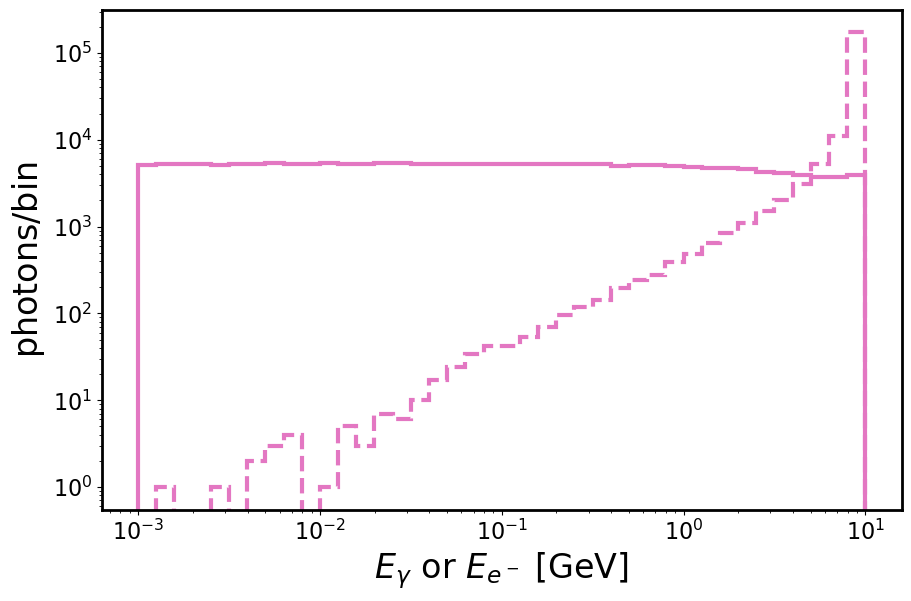

In [31]:
b0 = np.logspace(-3, 1, 41)

dens = False
plt.hist(Es, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='-', label=r"$\mathrm{SM,\ Ryan\ Approach}$")
plt.hist(EsE, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='--')

#plt.gca().legend(loc='best', fontsize=16, framealpha=1.0)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_\gamma\ \mathrm{or}\ E_{e^-}\ [\mathrm{GeV}]$", fontsize=24)
plt.gca().set_ylabel(r"$\mathrm{photons/bin}$", fontsize=24)
#plt.gca().axis([1e-3,100,1e-11,1e-3])
[l.set_size(16) for l in plt.gca().get_xticklabels()]
[l.set_size(16) for l in plt.gca().get_yticklabels()]

set_size(8.0, 5.0)


### Look at angular distributions of outgoing particles from bremsstrahlung/pair production in terms of their $p_T/p_z$

In [32]:
pTpz = np.array([(s[1].get_p0()[3]/np.sqrt(s[1].get_p0()[1]**2 + s[1].get_p0()[2]**2))**(-1) for s in s0])
pTpzE = np.array([(s[0].get_p0()[3]/np.sqrt(s[0].get_p0()[1]**2 + s[0].get_p0()[2]**2))**(-1) for s in s0])

pTpzG = np.array([(s[1].get_p0()[3]/np.sqrt(s[1].get_p0()[1]**2 + s[1].get_p0()[2]**2))**(-1) for s in s0G])
pTpzGP = np.array([(s[0].get_p0()[3]/np.sqrt(s[0].get_p0()[1]**2 + s[0].get_p0()[2]**2))**(-1) for s in s0G])

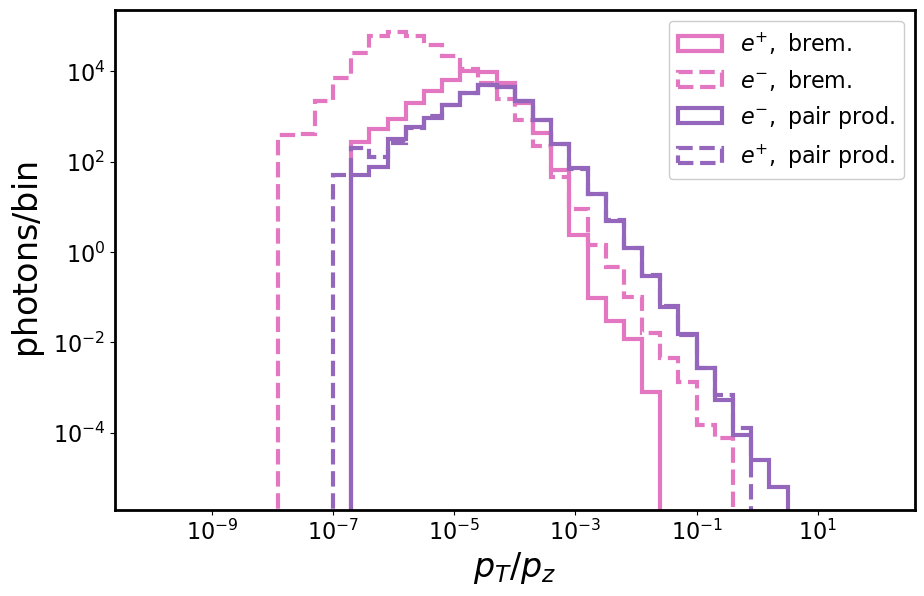

In [33]:
b0 = np.logspace(-10, 2, 41)

dens = True
plt.hist(pTpz, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='-', label=r"$e^{+},\ \rm{brem.}$")
plt.hist(pTpzE, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='--', label=r"$e^{-},\ \rm{brem.}$")

plt.hist(pTpzG, bins=b0, histtype='step', lw=3, color='C4', density=dens, ls='-', label=r"$e^{-},\ \rm{pair\ prod.}$")
plt.hist(pTpzGP, bins=b0, histtype='step', lw=3, color='C4', density=dens, ls='--', label=r"$e^{+},\ \rm{pair\ prod.}$")

plt.gca().legend(loc='best', fontsize=16, framealpha=1.0)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$p_T/p_z$", fontsize=24)
plt.gca().set_ylabel(r"$\mathrm{photons/bin}$", fontsize=24)
#plt.gca().axis([1e-3,100,1e-11,1e-3])
[l.set_size(16) for l in plt.gca().get_xticklabels()]
[l.set_size(16) for l in plt.gca().get_yticklabels()]

set_size(8.0, 5.0)


## Outgoing electron/positron energies coming from pair production: should be identical

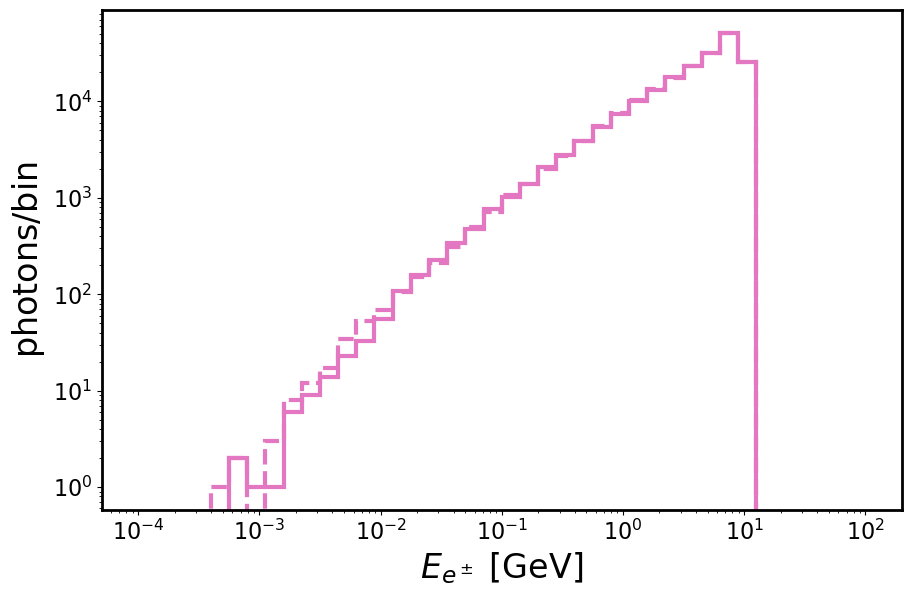

In [34]:
b0 = np.logspace(-4, 2, 41)

dens=False 

plt.hist(EsG, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='-')
plt.hist(EsGP, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='--')

#plt.gca().legend(loc=2, fontsize=16)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_{e^\pm}\ [\mathrm{GeV}]$", fontsize=24)
plt.gca().set_ylabel(r"$\mathrm{photons/bin}$", fontsize=24)
#plt.gca().axis([1e-3,100,1e-11,1e-3])
[l.set_size(16) for l in plt.gca().get_xticklabels()]
[l.set_size(16) for l in plt.gca().get_yticklabels()]

set_size(8.0, 5.0)


### Event-by-event ratio of $E_{e^-}/E_{e^+}$: should be symmetric about 1.

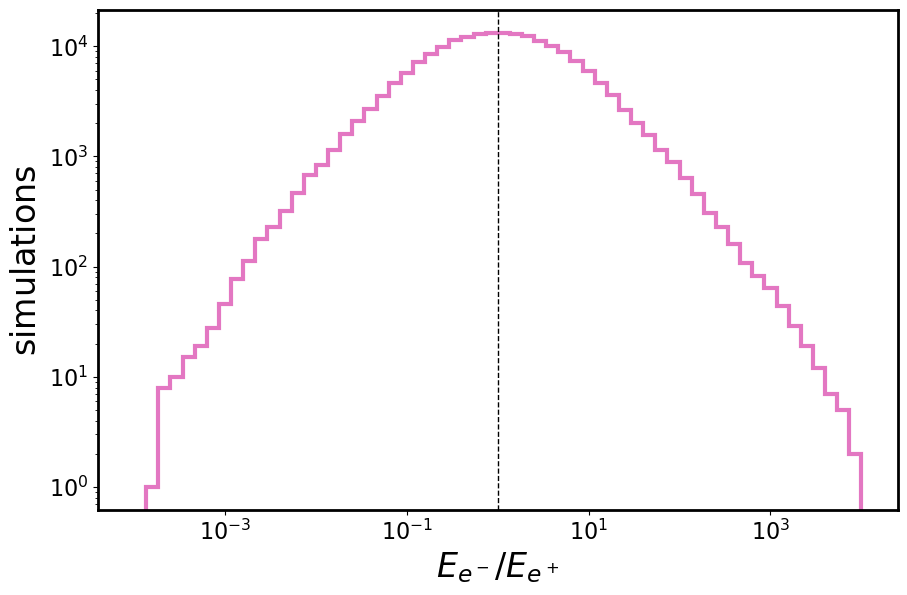

In [35]:
b0 = np.logspace(-4, 4, 61)

plt.hist(EsG/EsGP, bins=b0, histtype='step', lw=3, color='C6', density=False, ls='-', label=r"$\mathrm{SM,\ Ryan\ Approach}$")

#plt.gca().legend(loc=1, fontsize=16)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_{e^-}/E_{e^+}$", fontsize=24)
plt.gca().set_ylabel(r"$\mathrm{simulations}$", fontsize=24)
#plt.gca().axis([1e-3,100,1e-11,1e-3])
[l.set_size(16) for l in plt.gca().get_xticklabels()]
[l.set_size(16) for l in plt.gca().get_yticklabels()]
plt.gca().axvline(1.0, color='k', lw=1, ls='--')

set_size(8.0, 5.0)


### Asymmetry of the distribution. 

A basic test is distributions should be symmetric under  $e^+\leftrightarrow e^-$. We expect deviations due to statistical flucutations, on the order of $1/\sqrt{N}$ where $N$ is the size of the sample.

In [36]:
print("Asyymetry", (len(np.where(EsG > E0/2)[0]) - len(np.where(EsG < E0/2)[0]))/len(EsG) ) 
print("Statistical Error:" , 1/np.sqrt(len(EsG)) )


Asyymetry 0.00322
Statistical Error: 0.00223606797749979
